# Common Design Building Blocks

## Loading Libraries

In [11]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib
import matplotlib_inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Dataset's Iteration Performance
from tqdm import tqdm

# Time
import time

# OS
import sys
import string
import unicodedata
import requests, zipfile, io

# SciPy
from scipy.signal import convolve

# PyTorch
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import *
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


# IDLMAM Libraries
from idlmam import moveTo, run_epoch, set_seed
from idlmam import train_simple_network, set_seed, Flatten, weight_reset, train_network
from idlmam import LanguageNameDataset, pad_and_pack, EmbeddingPackable, LastTimeStep, LambdaLayer


# Scikit-Learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#  IPython Display
from IPython.display import Latex
from IPython.display import display_pdf
from IPython.display import set_matplotlib_formats

### Visualization Set-Up

In [14]:
%matplotlib inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')

### Setting Seeds

In [15]:
torch.backends.cudnn.deterministic=True

set_seed(42)

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Loading Data

In [17]:
# Splitting Data
train_data = torchvision.datasets.FashionMNIST("./", train=True, transform=transforms.ToTensor(), download=True)

test_data = torchvision.datasets.FashionMNIST("./", train=True, transform=transforms.ToTensor(), download=True)

# Data Loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

test_loader = DataLoader(test_data, batch_size=128)

Setting Main Hyper-parameters as follows:

In [18]:
# Weights & Heights Dimensions
W, H = 28, 28 

# Input Size
D = 28*28 #28 * 28 images 

# Hidden Layer Size
n = 256 

# Channels
C = 1

# Layers
n_filters = 32

# Classes
classes = 10 

A Fully Connected & Convolutional Baseline

In [19]:
fc_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,  n), nn.Tanh(), 
    *[nn.Sequential(nn.Linear(n,  n),nn.Tanh()) for _ in range(5)], 
    nn.Linear(n, classes),
)

In [20]:
cnn_model = nn.Sequential(
    nn.Conv2d(C, n_filters, 3, padding=1),
                 nn.Tanh(),
    nn.Conv2d(n_filters, n_filters, 3, padding=1),
         nn.Tanh(),
    nn.Conv2d(n_filters, n_filters, 3, padding=1),
         nn.Tanh(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(n_filters, 2*n_filters, 3, padding=1),
     nn.Tanh(),
    nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1),
     nn.Tanh(),
    nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1),
     nn.Tanh(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(2*n_filters, 4*n_filters, 3, padding=1),
     nn.Tanh(),
    nn.Conv2d(4*n_filters, 4*n_filters, 3, padding=1),
     nn.Tanh(),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

Training Model

In [21]:
# Loss Function
loss_func = nn.CrossEntropyLoss()

# Training Procedure
fc_results = train_network(fc_model, 
loss_func, 
train_loader,
test_loader=test_loader,
epochs=10,
score_funcs={'Accuracy': accuracy_score},
device=device)

cnn_results = train_network(cnn_model, 
loss_func, 
train_loader, 
test_loader=test_loader, 
epochs=10, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

Training: 100%|█████████▉| 468/469 [00:28<00:00, 16.18it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:28<00:00, 16.48it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:28<00:00, 16.39it/s]
                                                           
Epoch: 100%|██████████| 10/10 [07:06<00:00, 42.68s/it]


In [22]:
del fc_model
del cnn_model

Current Model Vs. Future Enhancement Visualization

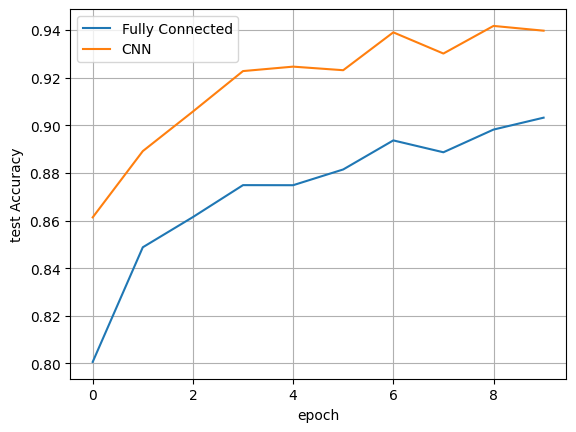

In [23]:
sns.lineplot(x='epoch', 
y='test Accuracy', 
data=fc_results, 
label='Fully Connected')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_results, 
label='CNN')

plt.grid(True)
plt.show()

## Better Activation Functions

### Vanishing Gradients

In [24]:
def sigmoid(x):
    return np.exp(activation_input)/(np.exp(activation_input)+1)

activation_input = np.linspace(-5, 5, num=200)
tanh_activation = np.tanh(activation_input)
sigmoid_activation = sigmoid(activation_input)

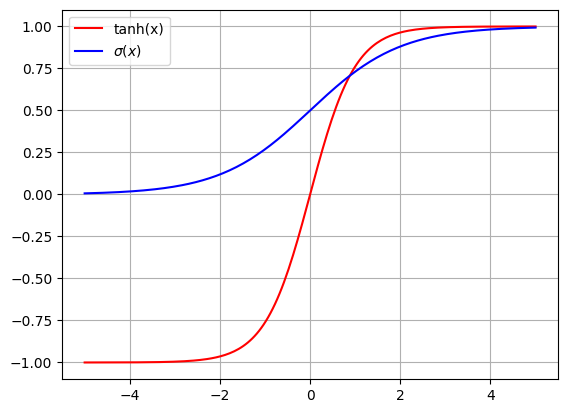

In [25]:
sns.lineplot(x=activation_input, 
y=tanh_activation, 
color='red', 
label="tanh(x)")

sns.lineplot(x=activation_input,
 y=sigmoid_activation, 
 color='blue', 
 label="$\sigma(x)$")

plt.grid(True)
plt.show()

Previous Function's Derivative as follows:

In [26]:
def tanh_deriv(x):
    return 1.0 - np.tanh(x)**2
def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

tanh_deriv = tanh_deriv(activation_input)
sigmoid_deriv = sigmoid_derivative(activation_input)

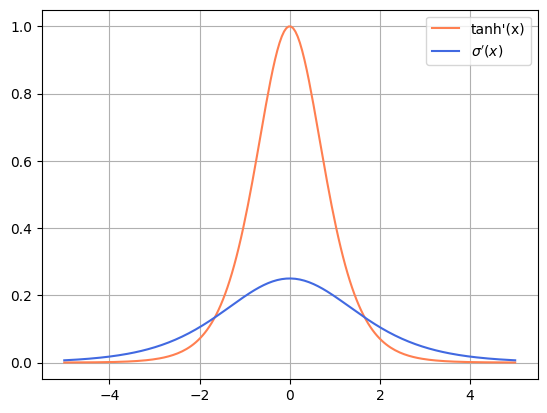

In [27]:
sns.lineplot(x=activation_input, 
y=tanh_deriv, 
color='coral', 
label="tanh'(x)")

sns.lineplot(x=activation_input, 
y=sigmoid_deriv, 
color='royalblue', 
label="$\sigma'(x)$")

plt.grid(True)
plt.show()

### Rectified Linear Units (ReLus): Avoiding Vanishing Gradients

Setting LeakyReLu as follows:

In [28]:
activation_input = np.linspace(-5, 5, num=200)

relu_activation = np.maximum(0,activation_input)

leaky_relu_activation = np.maximum(0.3*activation_input,activation_input)

<AxesSubplot: >

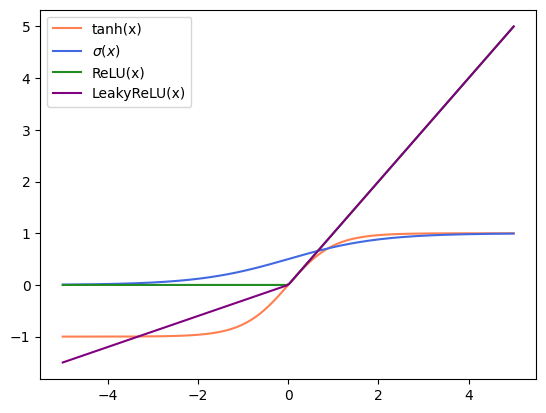

In [29]:
sns.lineplot(x=activation_input, 
y=tanh_activation, 
color='coral', 
label="tanh(x)")

sns.lineplot(x=activation_input, 
y=sigmoid_activation, 
color='royalblue', 
label="$\sigma(x)$")

sns.lineplot(x=activation_input, 
y=relu_activation, 
color='forestgreen', 
label="ReLU(x)")

sns.lineplot(x=activation_input, 
y=leaky_relu_activation, 
color='purple', 
label="LeakyReLU(x)")

Plotting Gradients

In [30]:
relu_deriv = 1.0*(activation_input > 0)

leaky_deriv = 1.0*(activation_input > 0) + 0.3*(activation_input <= 0)

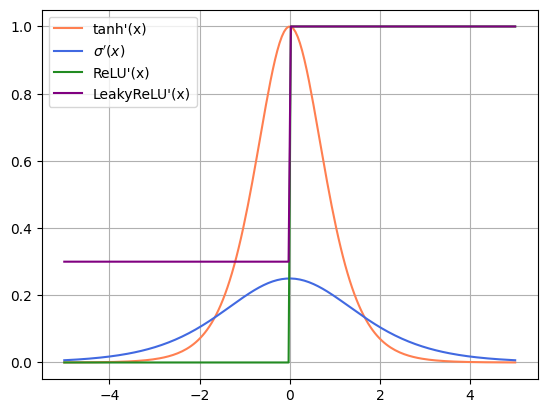

In [31]:
sns.lineplot(x=activation_input, 
y=tanh_deriv, 
color='coral', 
label="tanh'(x)")

sns.lineplot(x=activation_input, 
y=sigmoid_deriv, 
color='royalblue', 
label="$\sigma'(x)$")

sns.lineplot(x=activation_input, 
y=relu_deriv, 
color='forestgreen', 
label="ReLU'(x)")

sns.lineplot(x=activation_input, 
y=leaky_deriv, 
color='purple', 
label="LeakyReLU'(x)")

plt.grid(True)
plt.show()

### Training with LeakyReLu Activations

In [32]:
leak_rate = 0.1 

In [33]:
fc_relu_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,  n), 
    nn.LeakyReLU(leak_rate),
    *[nn.Sequential(nn.Linear(n,  n), 
    nn.LeakyReLU(leak_rate)) for _ in range(5)], 
    nn.Linear(n, classes),
)

In [34]:
def cnnLayer(in_filters, out_filters=None, kernel_size=3):
    if out_filters is None:
        out_filters = in_filters 
    padding=kernel_size//2 
    return nn.Sequential( 
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.LeakyReLU(leak_rate)
    )

In [35]:
cnn_relu_model = nn.Sequential(
    cnnLayer(C, n_filters), cnnLayer(n_filters),
     cnnLayer(n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters), 
    cnnLayer(2*n_filters), 
    cnnLayer(2*n_filters), 
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters),
     cnnLayer(4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

In [36]:
fc_relu_results = train_network(fc_relu_model, 
loss_func, 
train_loader, 
test_loader=test_loader, 
epochs=10, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

del fc_relu_model

cnn_relu_results = train_network(cnn_relu_model, 
loss_func, train_loader, 
test_loader=test_loader, 
epochs=10, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

del cnn_relu_model

Training: 100%|█████████▉| 468/469 [00:28<00:00, 16.68it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:28<00:00, 16.56it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:28<00:00, 16.65it/s]
                                                           
Epoch: 100%|██████████| 10/10 [07:11<00:00, 43.14s/it]


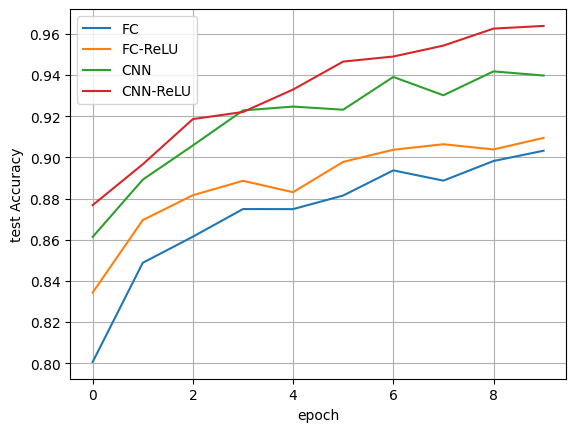

In [37]:
sns.lineplot(x='epoch', 
y='test Accuracy', 
data=fc_results, 
label='FC')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=fc_relu_results, 
label='FC-ReLU')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_results, 
label='CNN')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_relu_results, 
label='CNN-ReLU')

plt.grid(True)
plt.show()

## Normalization Layers: Magically Better Convergence.

### Training with Batch Normalization

In [38]:
fc_bn_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,  n), 
    nn.BatchNorm1d(n), 
    nn.LeakyReLU(leak_rate),
    *[nn.Sequential(nn.Linear(n,  n), 
    nn.BatchNorm1d(n), 
    nn.LeakyReLU(leak_rate)) for _ in range(5)], 
    nn.Linear(n, classes),
)

In [39]:
def cnnLayer(in_filters, out_filters=None, kernel_size=3):
    if out_filters is None:
        out_filters = in_filters 
    padding=kernel_size//2 
    return nn.Sequential( 
        nn.Conv2d(in_filters, 
        out_filters, 
        kernel_size, 
        padding=padding), 
        nn.BatchNorm2d(out_filters), 
        nn.LeakyReLU(leak_rate)
    )

In [40]:
cnn_bn_model = nn.Sequential(
    cnnLayer(C, n_filters), 
    cnnLayer(n_filters), 
    cnnLayer(n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters), 
    cnnLayer(2*n_filters), 
    cnnLayer(2*n_filters), 
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters), 
    cnnLayer(4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

In [41]:
fc_bn_results = train_network(fc_bn_model, 
loss_func, 
train_loader, 
test_loader=test_loader, 
epochs=10, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

del fc_bn_model

cnn_bn_results = train_network(cnn_bn_model, 
loss_func, 
train_loader, 
test_loader=test_loader, 
epochs=10, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

del cnn_bn_model

Training: 100%|█████████▉| 468/469 [00:30<00:00, 15.06it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:31<00:00, 15.22it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:31<00:00, 15.16it/s]
                                                           
Epoch: 100%|██████████| 10/10 [07:41<00:00, 46.12s/it]


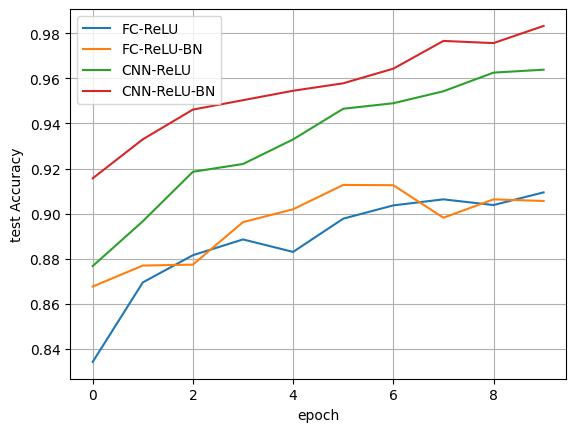

In [42]:
sns.lineplot(x='epoch', 
y='test Accuracy', 
data=fc_relu_results, 
label='FC-ReLU')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=fc_bn_results, 
label='FC-ReLU-BN')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_relu_results, 
label='CNN-ReLU')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_bn_results, 
label='CNN-ReLU-BN')

plt.grid(True)
plt.show()

### Training with Layer Normalization

Replacing BN with LN as follows:

In [43]:
fc_ln_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,  n), 
    nn.LayerNorm([n]), 
    nn.LeakyReLU(leak_rate),
    *[nn.Sequential(nn.Linear(n,  n), 
    nn.LayerNorm([n]), 
    nn.LeakyReLU(leak_rate)) for _ in range(5)], 
    nn.Linear(n, classes),
)

In [44]:
def cnnLayer(in_filters, out_filters=None, pool_factor=0,kernel_size=3):
    if out_filters is None:
        out_filters = in_filters 
    padding=kernel_size//2 
    return nn.Sequential( 
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.LayerNorm([out_filters, W//(2**pool_factor), H//(2**pool_factor)]),
        nn.LeakyReLU(leak_rate)
    )

Setting a Layer Normalization CNN as follows:

In [45]:
cnn_ln_model = nn.Sequential(
    cnnLayer(C, n_filters), 
    cnnLayer(n_filters), 
    cnnLayer(n_filters),
    nn.MaxPool2d((2,2)), 
    cnnLayer(n_filters, 2*n_filters, pool_factor=1), 
    cnnLayer(2*n_filters, pool_factor=1), 
    cnnLayer(2*n_filters, pool_factor=1), 
    nn.MaxPool2d((2,2)), 
    cnnLayer(2*n_filters, 4*n_filters, pool_factor=2), 
    cnnLayer(4*n_filters, pool_factor=2),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

In [46]:
fc_ln_results = train_network(fc_ln_model, 
loss_func, 
train_loader, 
test_loader=test_loader, 
epochs=10, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

del fc_ln_model

cnn_ln_results = train_network(cnn_ln_model, 
loss_func, 
train_loader, 
test_loader=test_loader, 
epochs=10, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

del cnn_ln_model

Training: 100%|█████████▉| 468/469 [00:31<00:00, 14.99it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:31<00:00, 14.52it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:31<00:00, 14.72it/s]
                                                           
Epoch: 100%|██████████| 10/10 [07:52<00:00, 47.25s/it]


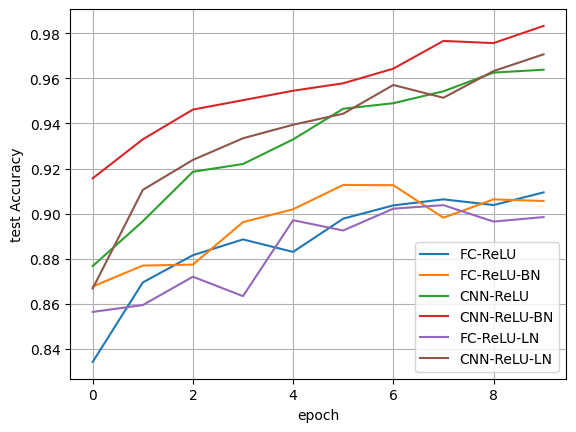

In [47]:
sns.lineplot(x='epoch', 
y='test Accuracy', 
data=fc_relu_results, 
label='FC-ReLU')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=fc_bn_results, 
label='FC-ReLU-BN')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_relu_results, 
label='CNN-ReLU')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_bn_results, 
label='CNN-ReLU-BN')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=fc_ln_results, 
label='FC-ReLU-LN')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_ln_results, 
label='CNN-ReLU-LN')

plt.grid(True)
plt.show()

## Skip Connections: A Network Design Pattern

### Implementing A Fully Connected Skips

In [48]:
class SkipFC(nn.Module):
    def __init__(self, n_layers, in_size, out_size, leak_rate=0.1):
        super().__init__()
        
        l = n_layers-1
        self.layers = nn.ModuleList([nn.Linear(in_size*l, out_size) if i == l else nn.Linear(in_size, in_size) for i in range(n_layers)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(out_size) if i == l else nn.BatchNorm1d(in_size) for i in range(n_layers)])
        self.activation = nn.LeakyReLU(leak_rate)
    
    def forward(self, x):
        activations = []
        
        for layer, bn in zip(self.layers[:-1], self.bns[:-1]):
            x = self.activation(bn(layer(x)))
            activations.append( x )
        
        x = torch.cat(activations, dim=1)
        return self.activation(self.bns[-1](self.layers[-1](x)))

In [49]:
fc_skip_model = nn.Sequential(
    nn.Flatten(),
    SkipFC(2, D, n),
    SkipFC(2, n, n),
    SkipFC(2, n, n),
    nn.Linear(n, classes),
)

In [50]:
fc_skip_results = train_network(fc_skip_model,
 loss_func, 
 train_loader, 
 test_loader=test_loader, 
 epochs=10, 
 score_funcs={'Accuracy': accuracy_score}, 
 device=device)

del fc_skip_model

Training: 100%|█████████▉| 468/469 [00:12<00:00, 36.29it/s]
                                                           
Training: 100%|██████████| 469/469 [00:12<00:00, 35.93it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:12<00:00, 38.60it/s]
                                                           
Training: 100%|██████████| 469/469 [00:12<00:00, 35.34it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:12<00:00, 35.47it/s]
                                                           
Epoch: 100%|██████████| 10/10 [03:44<00:00, 22.44s/it]


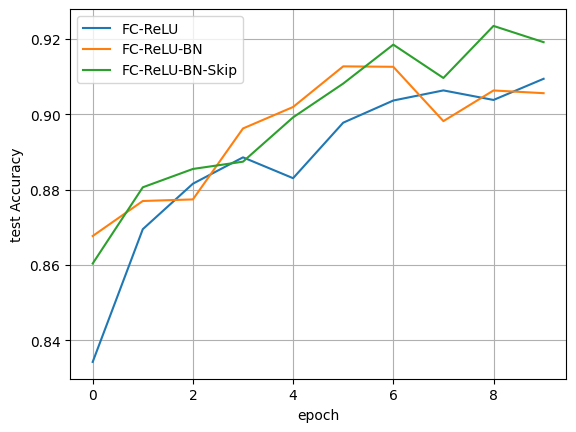

In [51]:
sns.lineplot(x='epoch', y='test Accuracy', data=fc_relu_results, label='FC-ReLU')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_bn_results, label='FC-ReLU-BN')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_skip_results, label='FC-ReLU-BN-Skip')

plt.grid(True)
plt.show()

### Implementing Convolutional Skips

Adding some helpers for Kernel Size & Padding as follows:

In [52]:
class SkipConv2d(nn.Module):
    def __init__(self, n_layers, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        
        l = n_layers-1
        f = (kernel_size, kernel_size)
        pad = (kernel_size-1)//2
        
        self.layers = nn.ModuleList([nn.Conv2d(in_channels*l, out_channels, kernel_size=f, padding=pad) if i == l else nn.Conv2d(in_channels, in_channels, kernel_size=f, padding=pad) for i in range(n_layers)])
        self.bns = nn.ModuleList([nn.BatchNorm2d(out_channels) if i == l else nn.BatchNorm2d(in_channels) for i in range(n_layers)])
        
        self.activation = nn.LeakyReLU(leak_rate)
    
    def forward(self, x):
        #
        activations = []
        
        for layer, bn in zip(self.layers[:-1], self.bns[:-1]):
            x = self.activation(bn(layer(x)))
            activations.append( x )

        x = torch.cat(activations, dim=1)
        
        return self.activation(self.bns[-1](self.layers[-1](x)))

In [53]:
cnn_skip_model = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1), 
    SkipConv2d(3, n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    nn.LeakyReLU(),
    SkipConv2d(3, 2*n_filters, 4*n_filters),
    nn.MaxPool2d((2,2)),
    SkipConv2d(2, 4*n_filters, 4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)


In [54]:
cnn_skip_results = train_network(cnn_skip_model, loss_func, train_loader, test_loader=test_loader, epochs=10, score_funcs={'Accuracy': accuracy_score}, device=device)

del cnn_skip_model

Training: 100%|█████████▉| 468/469 [00:50<00:00,  9.19it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:51<00:00,  9.02it/s]
                                                           
Epoch: 100%|██████████| 10/10 [12:02<00:00, 72.22s/it]


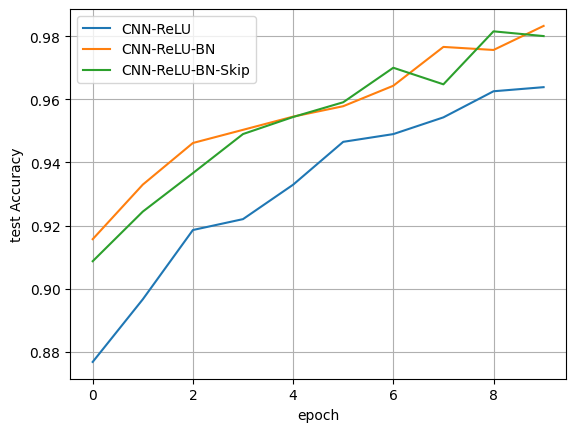

In [55]:
sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_relu_results, 
label='CNN-ReLU')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_bn_results, 
label='CNN-ReLU-BN')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_skip_results, 
label='CNN-ReLU-BN-Skip')

plt.grid(True)
plt.show()

## 1 x 1 Convolutions: Sharing & Reshaping Information in Channels

### Training with 1 x 1 Convolutions

In [56]:
def infoShareBlock(n_filters):
    return nn.Sequential(
        nn.Conv2d(n_filters, n_filters, (1,1), padding=0), 
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU())

In [57]:
def cnnLayer(in_filters, out_filters=None, kernel_size=3):
    if out_filters is None:
        out_filters = in_filters 
    padding=kernel_size//2 
    return nn.Sequential( 
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.BatchNorm2d(out_filters), 
        nn.LeakyReLU(leak_rate)
    )

In [58]:
cnn_1x1_model = nn.Sequential(
    cnnLayer(C, n_filters), 
    cnnLayer(n_filters),
    infoShareBlock(n_filters), 
    cnnLayer(n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters), 
    cnnLayer(2*n_filters),
    infoShareBlock(2*n_filters),
    cnnLayer(2*n_filters), 
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters), 
    cnnLayer(4*n_filters),
    infoShareBlock(4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

In [59]:
cnn_1x1_results = train_network(cnn_1x1_model, 
loss_func, 
train_loader, 
test_loader=test_loader, 
epochs=10, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

del cnn_1x1_model

Training: 100%|█████████▉| 468/469 [00:35<00:00, 13.40it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:35<00:00, 13.33it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:35<00:00, 13.10it/s]
                                                           
Epoch: 100%|██████████| 10/10 [08:30<00:00, 51.08s/it]


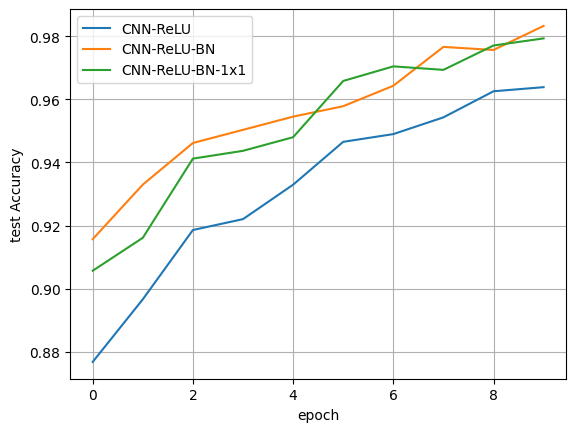

In [60]:
sns.lineplot(x='epoch', 
    y='test Accuracy', 
    data=cnn_relu_results, 
    label='CNN-ReLU')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_bn_results, 
label='CNN-ReLU-BN')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_1x1_results, 
label='CNN-ReLU-BN-1x1')

plt.grid(True)
plt.show()

## Residual Connections

### Implementing Residual Blocks

In [61]:
class ResidualBlockE(nn.Module):
    def __init__(self, channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        pad = (kernel_size-1)//2
        
        self.F = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(leak_rate),
        )
     
    def forward(self, x):
        return x + self.F(x)

### Implementing Residual Bottlenecks

In [62]:
class ResidualBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        pad = (kernel_size-1)//2
        bottleneck = max(out_channels//4, in_channels)
        self.F = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(in_channels, bottleneck, 1, padding=0),
            nn.BatchNorm2d(bottleneck),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            nn.BatchNorm2d(bottleneck),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, out_channels, 1, padding=0)
        )

        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut =  nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, padding=0), 
                    nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        return self.shortcut(x) + self.F(x) 

In [63]:
cnn_res_model = nn.Sequential(
    ResidualBottleNeck(C, n_filters), 
    nn.LeakyReLU(leak_rate), 
    ResidualBlockE(n_filters),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    ResidualBottleNeck(n_filters, 2*n_filters),
    nn.LeakyReLU(leak_rate),
    ResidualBlockE(2*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    ResidualBottleNeck(2*n_filters, 4*n_filters),
    nn.LeakyReLU(leak_rate),
    ResidualBlockE(4*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

In [64]:
cnn_res_results = train_network(cnn_res_model, 
loss_func, 
train_loader, 
test_loader=test_loader, 
epochs=10, 
score_funcs={'Accuracy': accuracy_score}, 
device=device)

Training: 100%|█████████▉| 468/469 [00:43<00:00, 10.86it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:43<00:00, 10.84it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:43<00:00, 10.87it/s]
                                                           
Epoch: 100%|██████████| 10/10 [10:07<00:00, 60.80s/it]


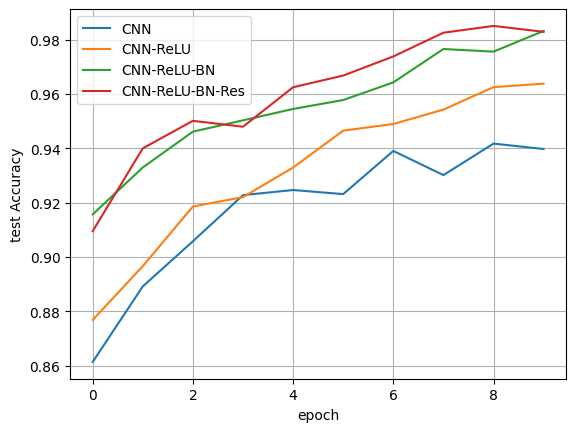

In [65]:
sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_results, 
label='CNN')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_relu_results, 
label='CNN-ReLU')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_bn_results, 
label='CNN-ReLU-BN')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=cnn_res_results, 
label='CNN-ReLU-BN-Res')

plt.grid(True)
plt.show()

## Long Short-Term Memory RNN's

### Training a LSTM

In [66]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io

r = requests.get(zip_file_url)

z = zipfile.ZipFile(io.BytesIO(r.content))

z.extractall()

#Zip file is organized as data/names/[LANG].txt , where [LANG] is a specific language

namge_language_data = {}

In [67]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names 

In [68]:
# Dataset
dataset = LanguageNameDataset(namge_language_data, alphabet)

# Train Split
train_lang_data, test_lang_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))

# Data Loader
train_lang_loader = DataLoader(train_lang_data, batch_size=32, shuffle=True, collate_fn=pad_and_pack)

test_lang_loader = DataLoader(test_lang_data, batch_size=32, shuffle=False, collate_fn=pad_and_pack)

In [69]:
rnn_3layer = nn.Sequential( 
  EmbeddingPackable(nn.Embedding(len(all_letters), 64)), 
  nn.RNN(64, n, num_layers=3, batch_first=True), 
  LastTimeStep(rnn_layers=3), 
  nn.Linear(n, len(namge_language_data)), 
)

# Clip Gradients
for p in rnn_3layer.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

rnn_results = train_network(rnn_3layer, loss_func, train_lang_loader, test_loader=test_lang_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

Training: 100%|█████████▉| 616/618 [00:06<00:00, 100.34it/s]
                                                            
Training:  99%|█████████▉| 612/618 [00:06<00:00, 97.96it/s]
                                                           
Training: 100%|██████████| 618/618 [00:06<00:00, 102.20it/s]
                                                            
Training:  99%|█████████▉| 612/618 [00:06<00:00, 101.42it/s]
                                                            
Training:  98%|█████████▊| 608/618 [00:06<00:00, 98.97it/s]
                                                           
Training:  98%|█████████▊| 608/618 [00:06<00:00, 101.05it/s]
                                                            
Training: 100%|█████████▉| 615/618 [00:06<00:00, 103.27it/s]
                                                            
Training: 100%|█████████▉| 617/618 [00:06<00:00, 98.11it/s]
                                                           
Training:  98%|█████████▊| 608

In [70]:
lstm_3layer = nn.Sequential(
  EmbeddingPackable(nn.Embedding(len(all_letters), 64)), 
  nn.LSTM(64, n, num_layers=3, batch_first=True), 
  LastTimeStep(rnn_layers=3), 
  nn.Linear(n, len(namge_language_data)), 
)

for p in lstm_3layer.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

In [71]:
lstm_results = train_network(lstm_3layer, 
loss_func, 
train_lang_loader, 
test_loader=test_lang_loader, 
score_funcs={'Accuracy': accuracy_score}, 
device=device, epochs=10)

Training: 100%|██████████| 618/618 [00:09<00:00, 66.67it/s]
                                                           
Training: 100%|█████████▉| 617/618 [00:09<00:00, 68.42it/s]
                                                           
Training:  99%|█████████▉| 614/618 [00:09<00:00, 67.19it/s]
                                                           
Training:  99%|█████████▉| 613/618 [00:09<00:00, 56.57it/s]
                                                           
Training: 100%|█████████▉| 615/618 [00:09<00:00, 67.64it/s]
                                                           
Training:  99%|█████████▉| 612/618 [00:09<00:00, 67.71it/s]
                                                           
Training:  99%|█████████▉| 614/618 [00:09<00:00, 68.03it/s]
                                                           
Training: 100%|█████████▉| 616/618 [00:09<00:00, 68.17it/s]
                                                           
Training:  99%|█████████▉| 614/618 [00:0

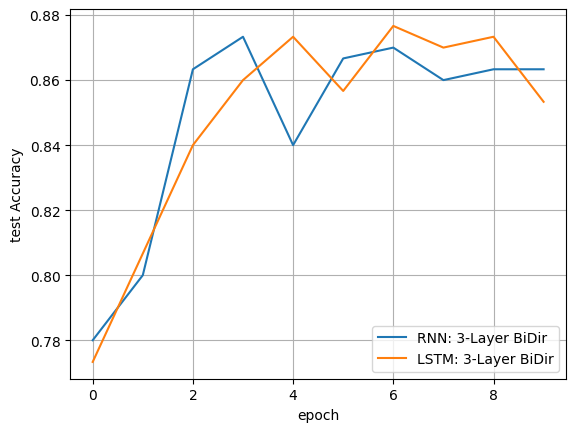

In [72]:
sns.lineplot(x='epoch', 
y='test Accuracy', 
data=rnn_results, 
label='RNN: 3-Layer BiDir')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=lstm_results, 
label='LSTM: 3-Layer BiDir')

plt.grid(True)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=58a6685c-d463-45c7-8388-88eb6faa04f5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>